In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import scipy.integrate as integ
from scipy.optimize import curve_fit
import simulation_utility as su
import time
import json
import os

SIMULATION WITH 1PE (V)

Number of waveforms 10005, time to read 7.91


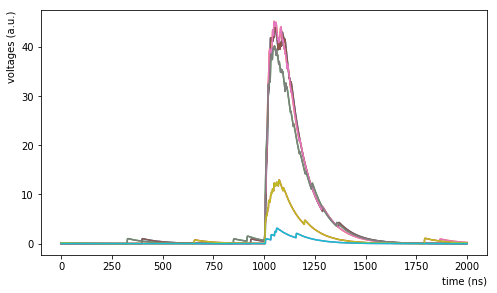

In [2]:
wfs1 = su.read_waveforms_from_json(PE = 1, plot=True)

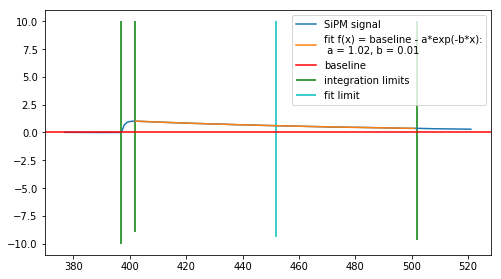

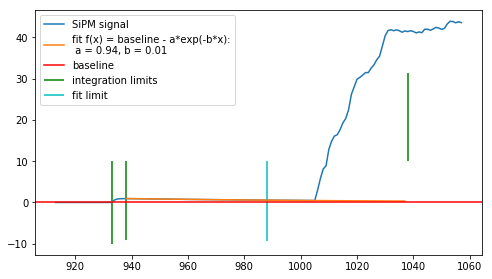

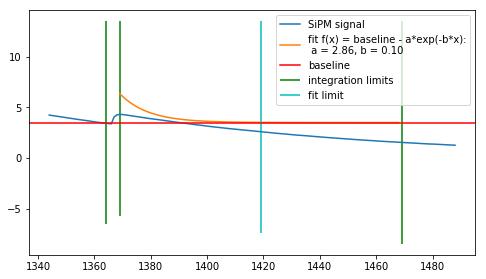

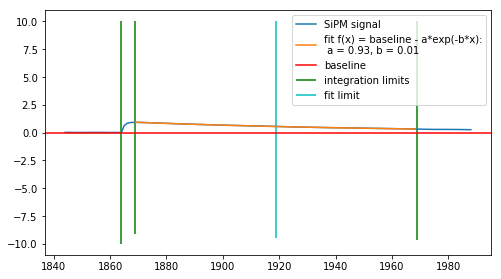

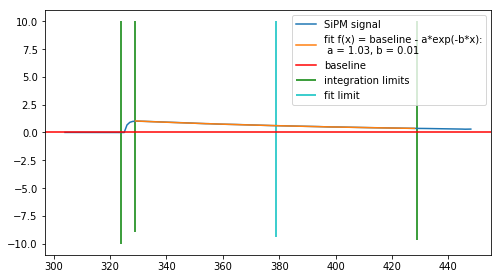

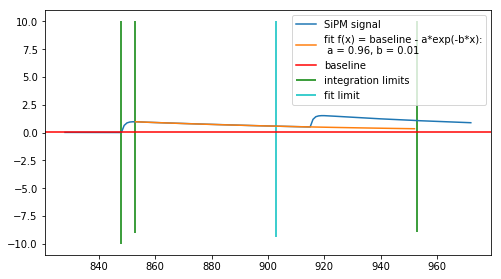

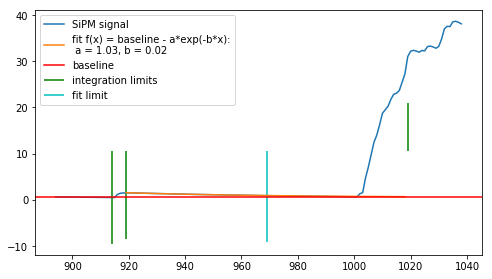

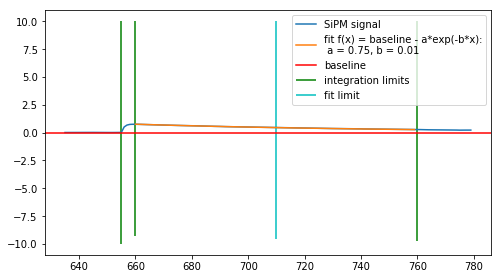

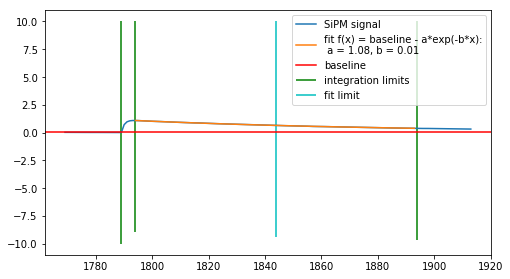

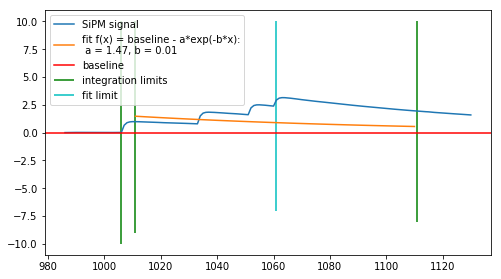

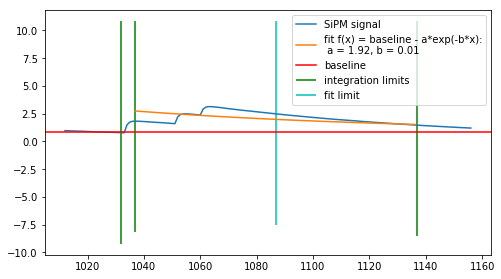

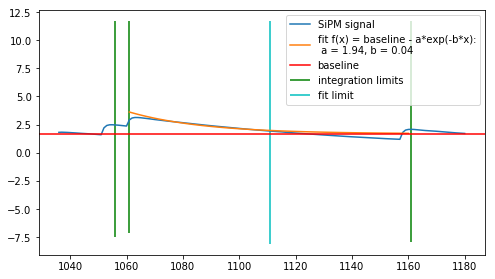

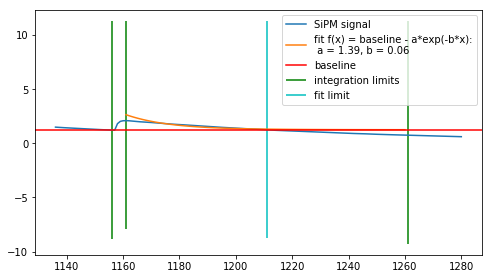

In [3]:
for i in range(5) :
    listpeaks = su.search_peaks(wfs1[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs1[i],listpeaks,-5,0,50,100,5,8,10,plot=1,central=0)

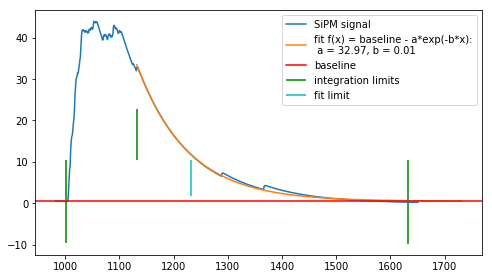

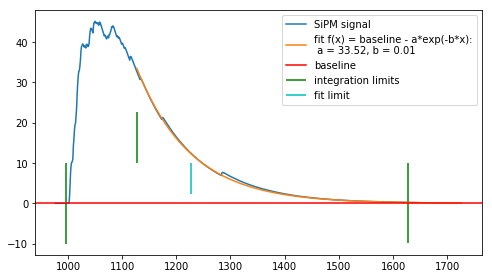

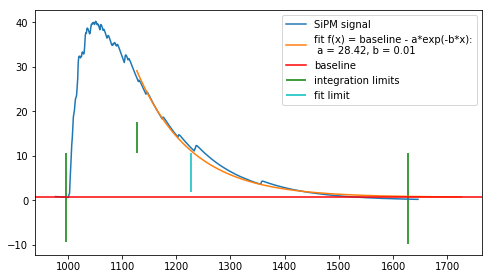

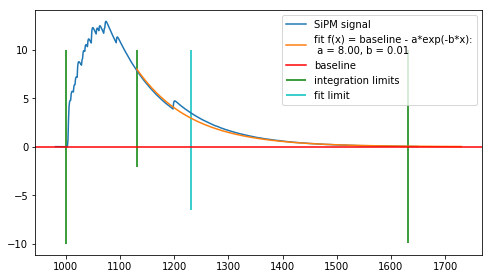

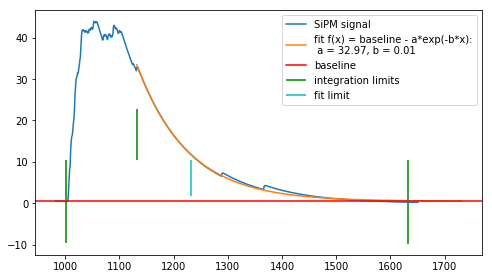

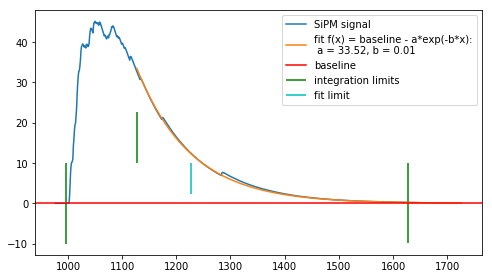

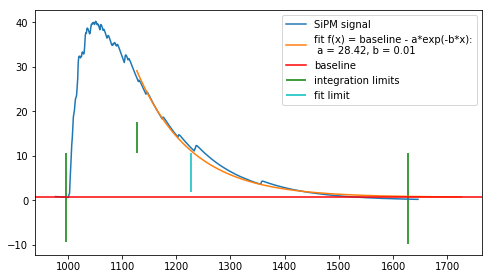

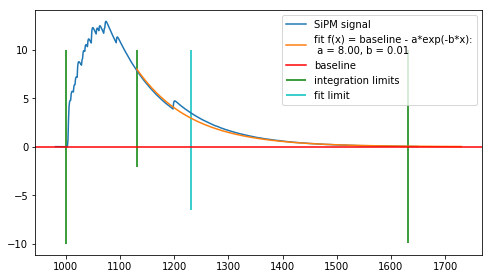

In [4]:
for i in range(10):
    listpeaks = su.search_peaks(wfs1[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs1[i],listpeaks,-30,100,200,600,15,8,10,plot=1)

event n. 0 time to process: 0.01
event n. 1000 time to process: 9.54
event n. 2000 time to process: 18.86
event n. 3000 time to process: 28.11
event n. 4000 time to process: 37.07
event n. 5000 time to process: 45.98
event n. 6000 time to process: 54.97
event n. 7000 time to process: 64.08
event n. 8000 time to process: 73.05
event n. 9000 time to process: 82.57
event n. 10000 time to process: 91.60
n. events: 1PE=7264


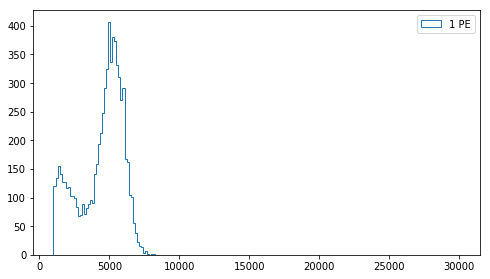

In [5]:
integrals1 = su.calculate_integrals(wfs1,PE=1,angle=0)

SIMULATION WITH 2PE (V)

Number of waveforms 10005, time to read 8.09


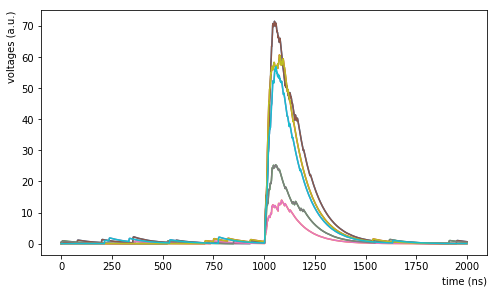

In [3]:
wfs2 = su.read_waveforms_from_json(PE = 2, plot = True)

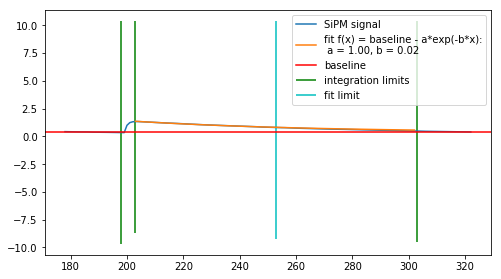

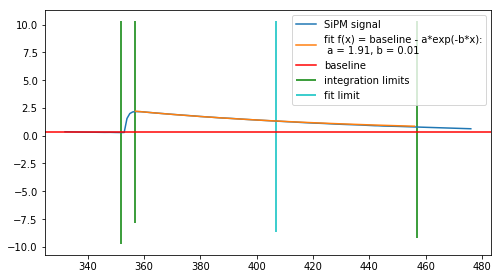

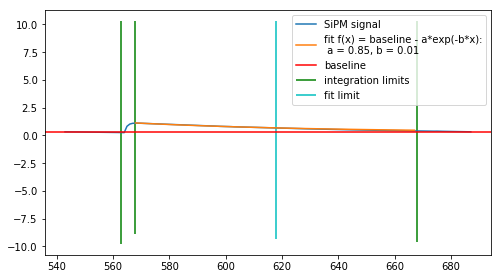

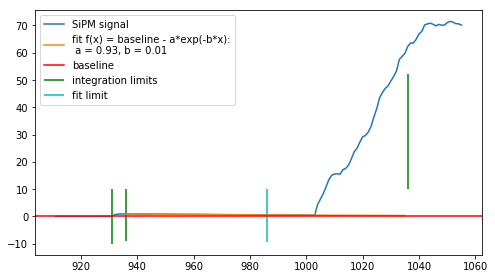

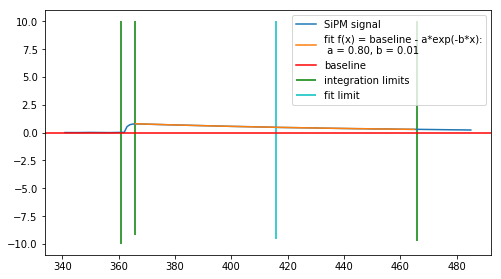

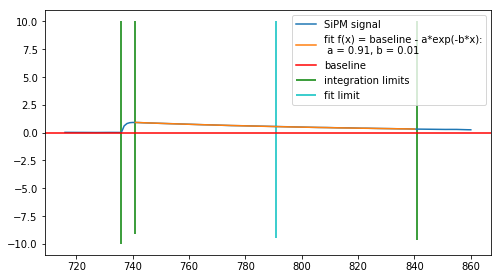

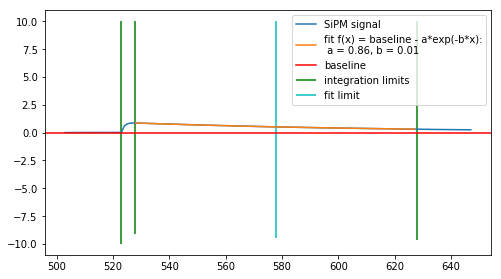

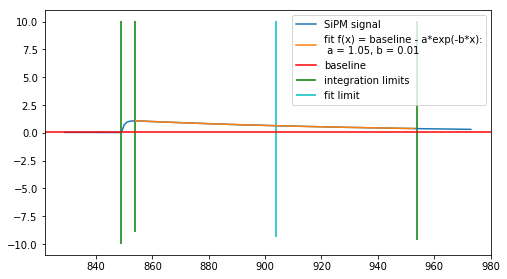

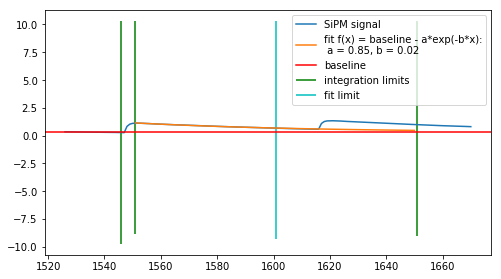

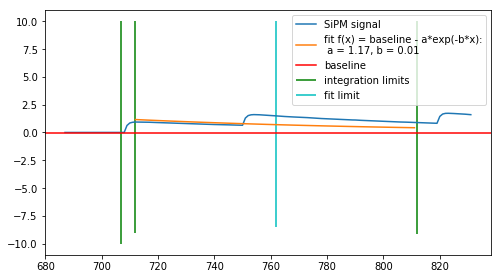

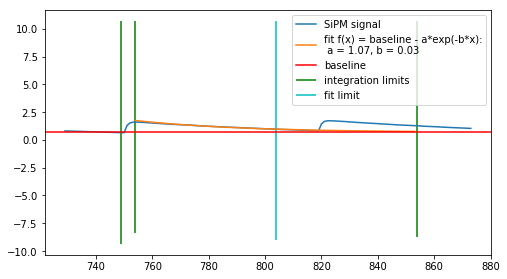

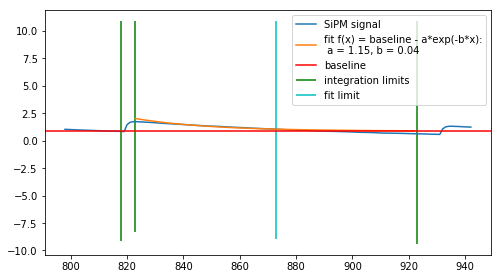

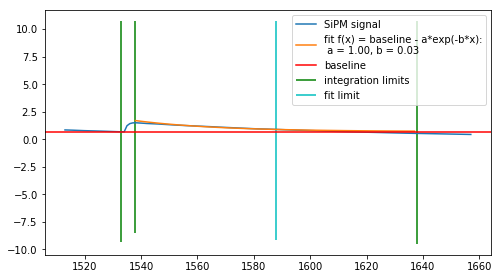

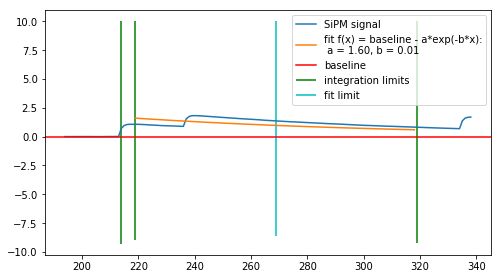

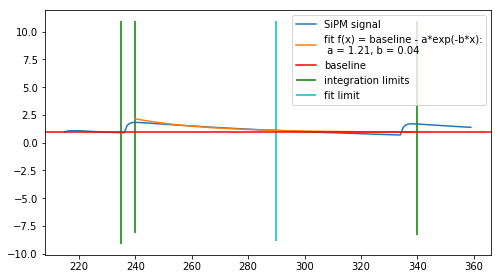

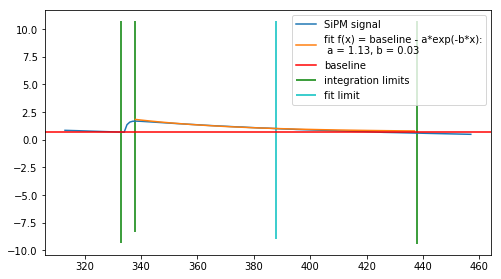

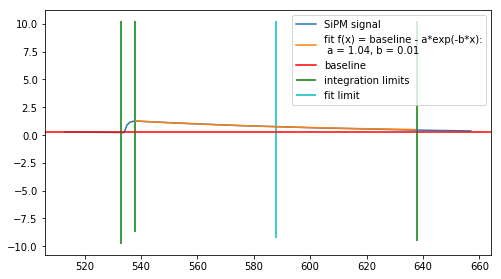

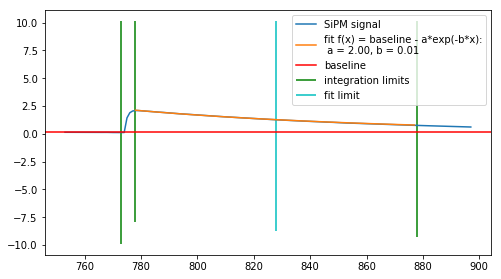

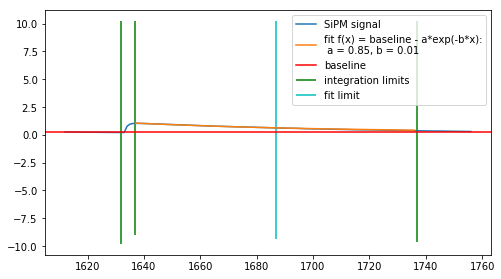

In [6]:
for i in range(5) :
    listpeaks = su.search_peaks(wfs2[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs2[i],listpeaks,-5,0,50,100,5,8,10,plot=1,central=0)

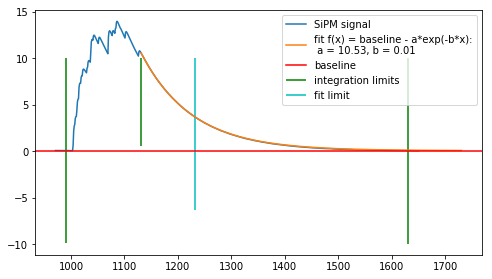

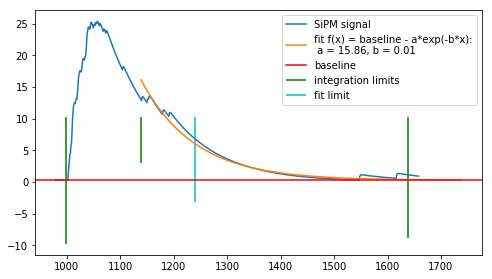

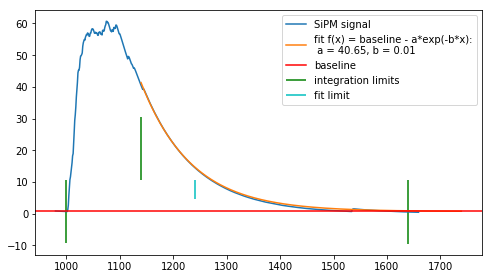

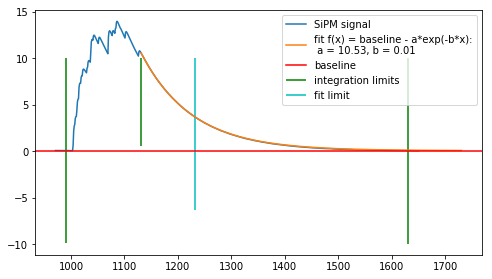

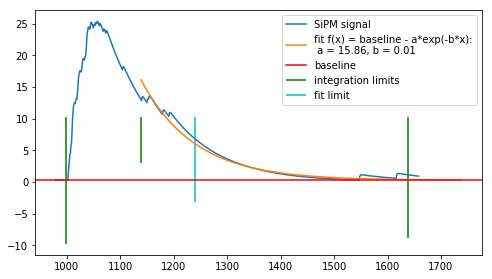

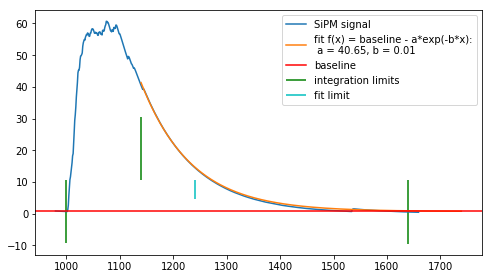

In [7]:
for i in range(10):
    listpeaks = su.search_peaks(wfs2[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs2[i],listpeaks,-40,100,200,600,15,8,10,plot=1)

event n. 0 time to process: 0.00
event n. 1000 time to process: 5.72
event n. 2000 time to process: 11.81
event n. 3000 time to process: 17.70
event n. 4000 time to process: 23.52
event n. 5000 time to process: 29.11
event n. 6000 time to process: 35.02
event n. 7000 time to process: 40.98
event n. 8000 time to process: 46.75
event n. 9000 time to process: 52.60
event n. 10000 time to process: 58.32
n. events: 2PE=6514


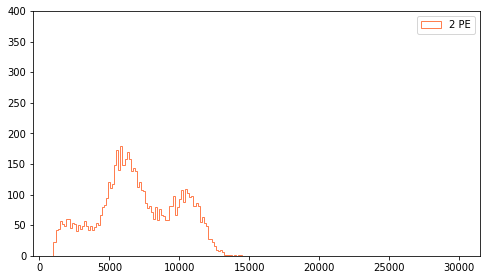

In [5]:
integrals2 = su.calculate_integrals(wfs2,PE=2,angle=0)

SIMULATION WITH 3PE (V)

Number of waveforms 10005, time to read 8.04


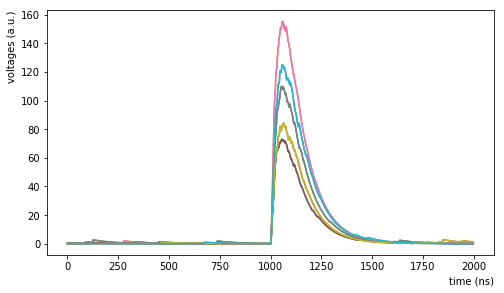

In [4]:
wfs3 = su.read_waveforms_from_json(PE = 3, plot = True)

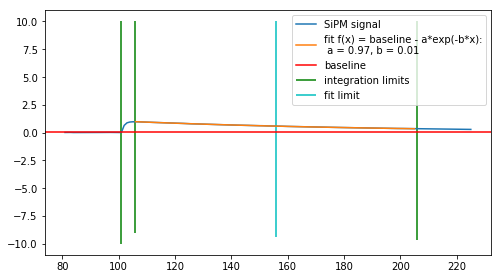

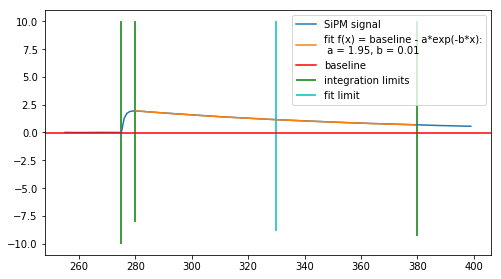

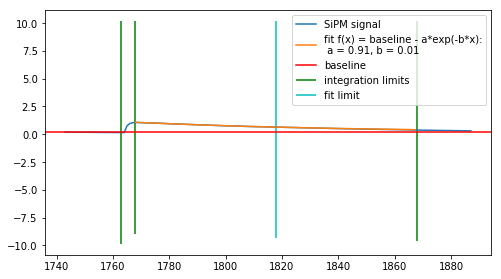

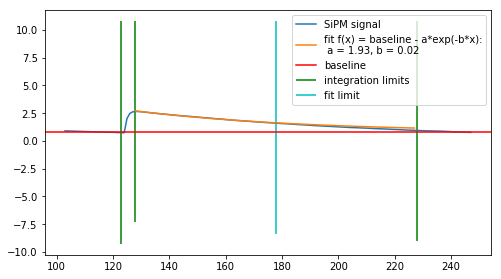

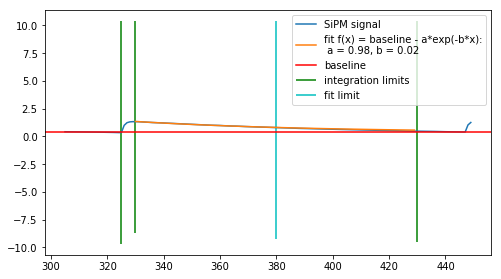

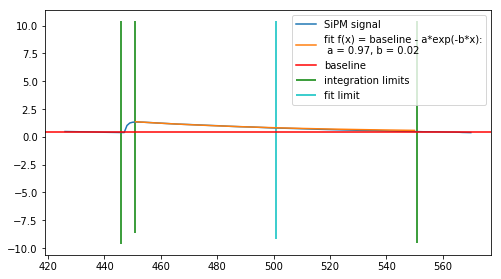

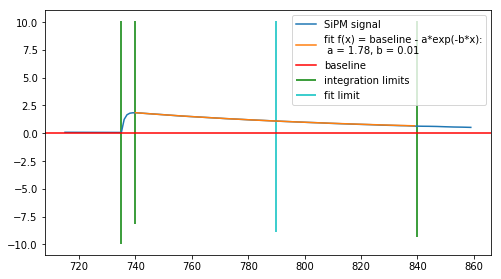

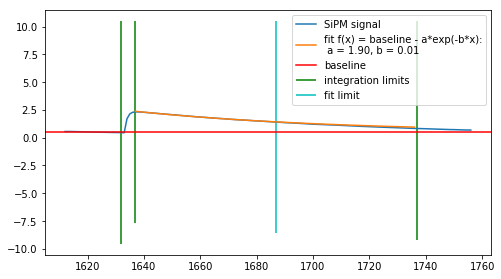

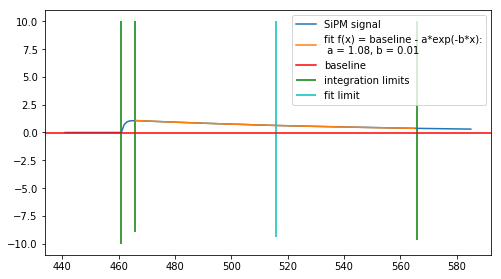

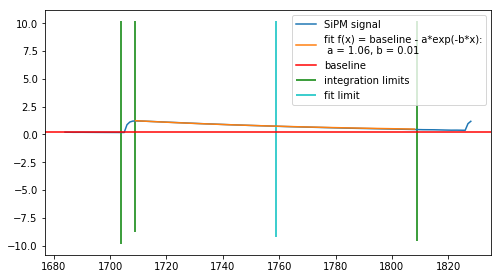

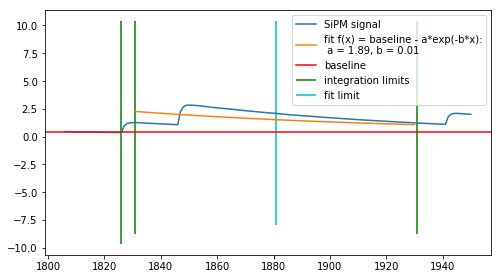

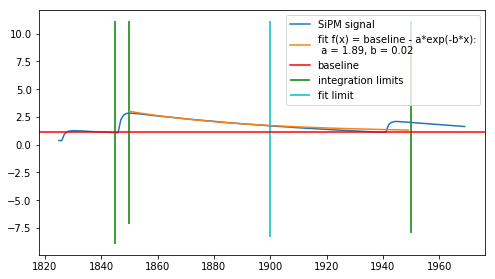

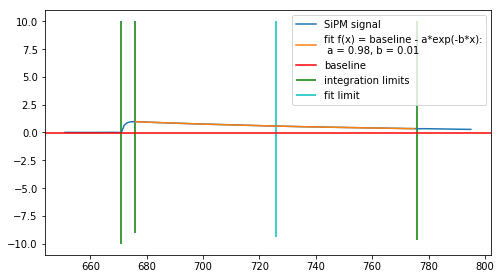

In [9]:
for i in range(5) :
    listpeaks = su.search_peaks(wfs3[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs3[i],listpeaks,-5,0,50,100,5,8,10,plot=1,central=0)

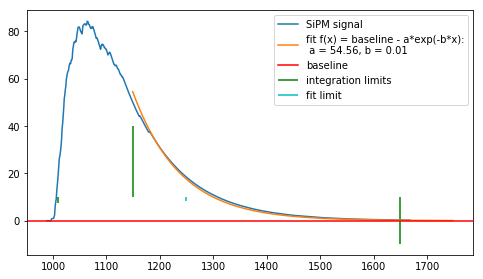

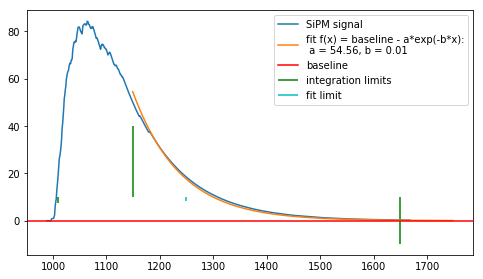

In [10]:
for i in range(10):
    listpeaks = su.search_peaks(wfs3[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs3[i],listpeaks,-40,100,200,600,15,8,10,plot=1)

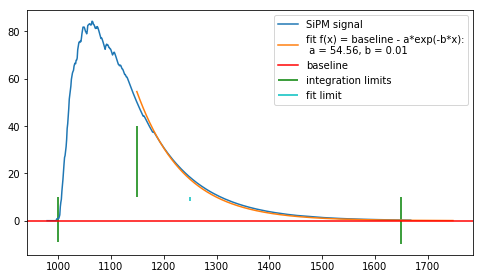

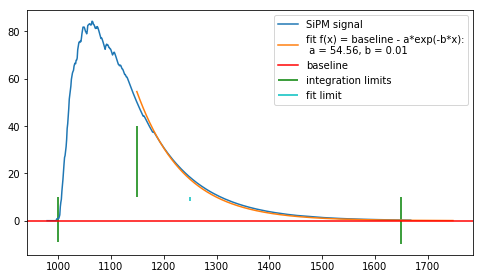

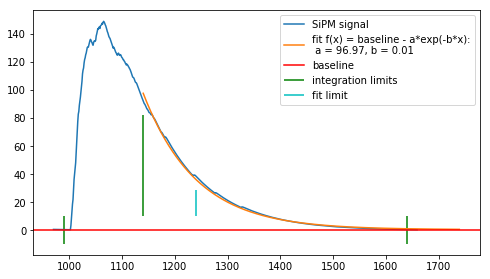

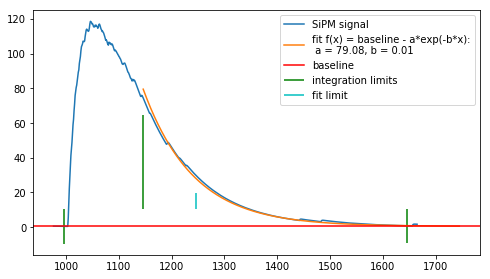

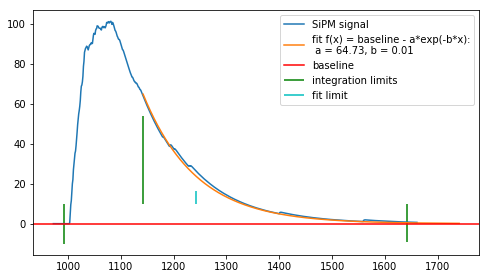

In [11]:
for i in range(20):
    listpeaks = su.search_peaks(wfs3[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs3[i],listpeaks,-50,100,200,600,15,8,10,plot=1)

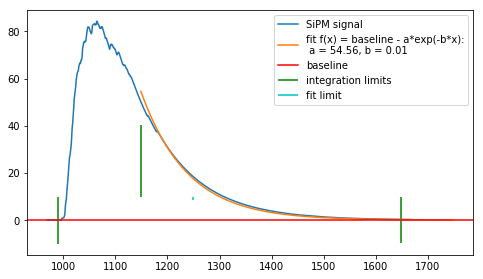

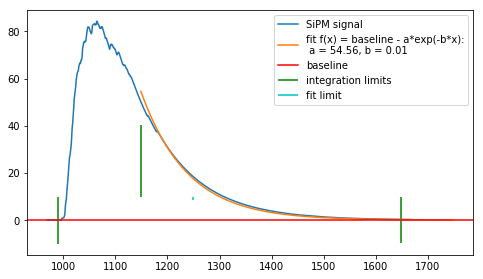

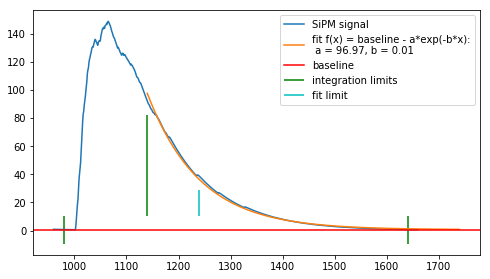

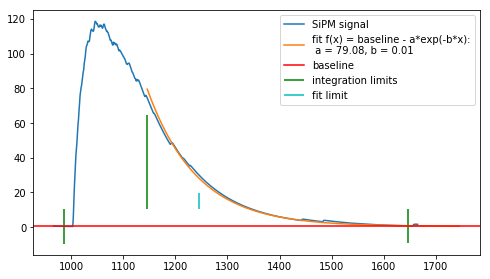

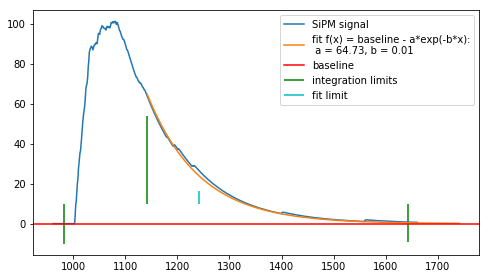

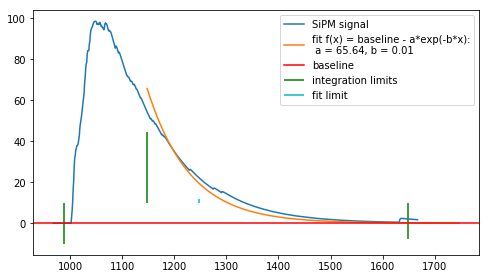

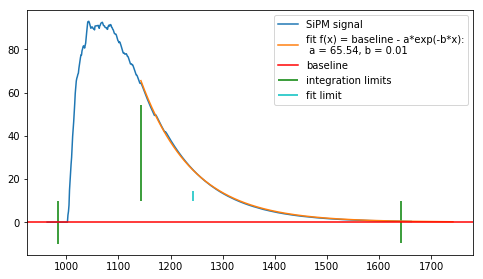

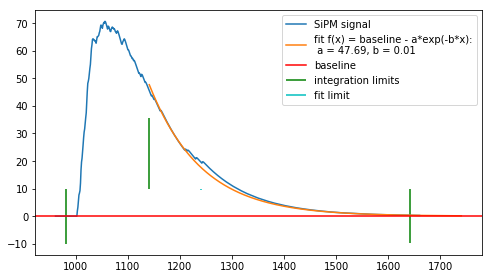

In [12]:
for i in range(30):
    listpeaks = su.search_peaks(wfs3[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs3[i],listpeaks,-60,100,200,600,15,8,10,plot=1)

event n. 0 time to process: 0.00
event n. 1000 time to process: 4.52
event n. 2000 time to process: 9.00
event n. 3000 time to process: 13.48
event n. 4000 time to process: 17.96
event n. 5000 time to process: 22.48
event n. 6000 time to process: 27.10
event n. 7000 time to process: 31.47
event n. 8000 time to process: 35.83
event n. 9000 time to process: 40.52
event n. 10000 time to process: 45.05
n. events: 3PE=4849


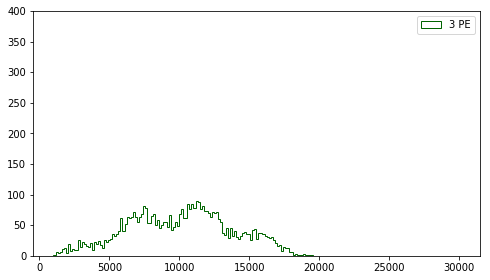

In [12]:
integrals3 = su.calculate_integrals(wfs3, PE = 3, angle = 0)

Number of waveforms 2280, time to read 1.78


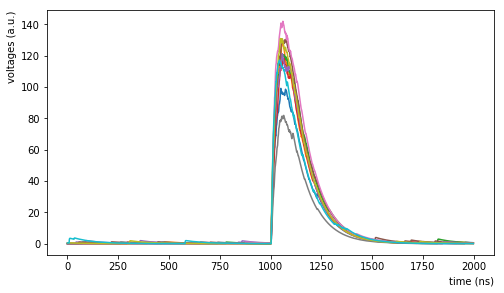

In [2]:
wfs4 = su.read_waveforms_from_json(PE = 4, plot=True)

In [ ]:
for i in range(5) :
    listpeaks = su.search_peaks(wfs4[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs4[i],listpeaks,-5,0,50,100,5,8,10,plot=1,central=0)

In [ ]:
integrals4 = su.calculate_integrals(wfs4, PE = 4, angle = 0)

HISTOGRAMS 1PE, 2PE, 3PE 

n. events: 1PE=7264, 2PE=6514, 3PE=4849


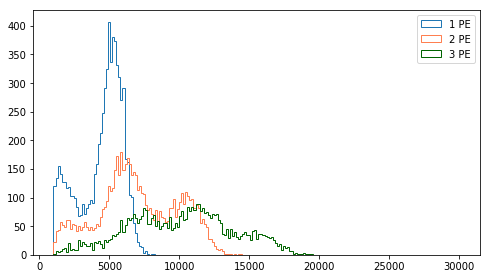

In [13]:
plt.figure(figsize=(8,4.5))
integrals1 = np.load(f'integrals/integrals_PE1_angle0.npy')
integrals2 = np.load(f'integrals/integrals_PE2_angle0.npy')
integrals3 = np.load(f'integrals/integrals_PE3_angle0.npy')
print(f'n. events: 1PE={len(integrals1)}, 2PE={len(integrals2)}, 3PE={len(integrals3)}')
a = plt.hist(integrals1,bins=200,range=(1000,30000),density=0,histtype='step',label=f'1 PE')
a = plt.hist(integrals2,bins=200,range=(1000,30000),density=0,histtype='step',label='2 PE',color='coral')
a = plt.hist(integrals3,bins=200,range=(1000,30000),density=0,histtype='step',label='3 PE', color= 'darkgreen')
#plt.ylim(0,400)
#plt.yscale('log')
plt.legend()

In [5]:
integrals1 = su.simple_integral_central_peak( wfs1, 70, 600)
integrals2 = su.simple_integral_central_peak( wfs2, 70, 600)
integrals3 = su.simple_integral_central_peak( wfs3, 70, 600)


n. events: 1PE=10005, 2PE=10005, 3PE=10005


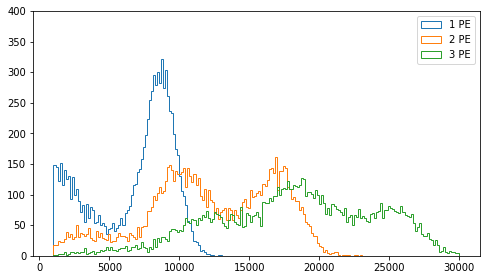

In [7]:
plt.figure(figsize=(8,4.5))
print(f'n. events: 1PE={len(integrals1)}, 2PE={len(integrals2)}, 3PE={len(integrals3)}')
a = plt.hist(integrals1,bins=200,range=(1000,30000),density=0,histtype='step',label='1 PE')
a = plt.hist(integrals2,bins=200,range=(1000,30000),density=0,histtype='step',label='2 PE')
a = plt.hist(integrals3,bins=200,range=(1000,30000),density=0,histtype='step',label='3 PE')
#plt.yscale('log')
plt.ylim(0,400)
plt.legend()